<a href="https://colab.research.google.com/github/filipemtz/neuralnets/blob/main/lstm_v3_temperatura_e_sensores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sklearn
import warnings
warnings.filterwarnings(action='ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

print(f"numpy:{np.__version__}")
print(f"pandas:{pd.__version__}")
print(f"sklearn:{sklearn.__version__}")
print(f"joblib:{joblib.__version__}")
print(f"tensorflow:{tf.__version__}")

numpy:1.19.5
pandas:1.1.5
sklearn:1.0.1
joblib:1.1.0
tensorflow:2.7.0


In [47]:
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

df_bf_t_model = pd.read_csv('AMT_BF_T_Model_Train_Test_RS.csv',date_parser=custom_date_parser,parse_dates=["Data"], index_col="Data")
df_bf_t_model.drop('Unnamed: 0', axis=1, inplace=True)

In [48]:
model_columns = ['Temperatura -  TE05B1_A','Temperatura -  TE12B1_A',
'Temperatura -  TE20B1_A' ,'Temperatura -  TE27B1_A',
'Temperatura -  TE35B1_A' ,'Temperatura -  TE42B1_A',
'Temperatura -  TE50B1_A' ,'Temperatura -  TE57B1_A',
'Temperatura -  TE49B1_B' ,'Temperatura -  TE41B1_B',
'Temperatura -  TE34B1_B' ,'Temperatura -  TE26B1_B',
'Temperatura -  TE11B1_B' ,'Temperatura -  TE04B1_B',
'Temperatura -  TE56B1_B' ,'Temperatura -  TE02B2_A',
'Temperatura -  TE08B2_A' ,'Temperatura -  TE14B2_A',
'Temperatura -  TE20B2_A' ,'Temperatura -  TE26B2_A',
'Temperatura -  TE32B2_A' ,'Temperatura -  TE38B2_A',
'Temperatura -  TE44B2_A' ,'Temperatura -  TE05B2_B',
'Temperatura -  TE23B2_B' ,'Temperatura -  TE41B2_B',
'Temperatura -  TE35B2_B' ,'Temperatura -  TE47B2_B',
'Carga Térmica na Ventaneira 1','Carga Térmica na Ventaneira 2','Carga Térmica na Ventaneira 3','Carga Térmica na Ventaneira 4',
'Carga Térmica na Ventaneira 5','Carga Térmica na Ventaneira 6','Carga Térmica na Ventaneira 7','Carga Térmica na Ventaneira 8',
'Carga Térmica na Ventaneira 9','Carga Térmica na Ventaneira 10','Carga Térmica na Ventaneira 11','Carga Térmica na Ventaneira 12',
'Carga Térmica na Ventaneira 13','Carga Térmica na Ventaneira 14','Carga Térmica na Ventaneira 15','Carga Térmica na Ventaneira 16',
'Carga Térmica na Ventaneira 17','Carga Térmica na Ventaneira 18','Carga Térmica na Ventaneira 19','Carga Térmica na Ventaneira 20',
'Carga Térmica na Ventaneira 21','Carga Térmica na Ventaneira 22','Carga Térmica na Ventaneira 23','Carga Térmica na Ventaneira 24',
'Carga Térmica na Ventaneira 25','Carga Térmica na Ventaneira 26','Carga Térmica na Ventaneira 27','Carga Térmica na Ventaneira 28',
'Carga Térmica na Ventaneira 29','Carga Térmica na Ventaneira 30','Carga Térmica na Ventaneira 31','Carga Térmica na Ventaneira 32',
'Carga Térmica na Ventaneira 33','Carga Térmica na Ventaneira 34','Carga Térmica na Ventaneira 35','Carga Térmica na Ventaneira 36',
'Carga Térmica na Ventaneira 37','Carga Térmica na Ventaneira 38',
'Volume de Sopro', 'Umidade do Ar de Sopro',
'Temperatura do Ar de Sopro','PCI Rate Calculado',
'Coque Rate_carga',
'Taxa de O2', 'Pressão do AR de Sopro',
'Pressão do Topo', 'Composição de H2 no Topo', 
'Índice de Permeabilidade 3', 'Taxa de Carvão O2', 'Vazão Gás Rampa', 'Relação CO/CO2',
'Velocidade de Produção de Gusa', 'Coque Rate', 
'Redução Direta', 'Perda Térmica do Stave', 
'Umidade na Carga (Kg/tg)',
'Escória Rate_carga','Relação M/C_carga', 'Umidade Coque_carga',
'Primeira_T_FG','FGND', 'FG1' ,'FG2' ,'FG3','FG4',
'CC1','CC2','CCND','TEMPERATURA']

df_bf_t_model = df_bf_t_model[model_columns]

In [49]:
df_bf_t_model["TEMPERATURA_ANTERIOR"] = df_bf_t_model['TEMPERATURA'].shift(1)

#Movimentação da coluna temperatura para ela ser a última coluna do dataset
df_bf_t_model.rename(columns={"TEMPERATURA": "TEMPERATURA_TO_REMOVE"},inplace=True)
df_bf_t_model['TEMPERATURA'] = df_bf_t_model['TEMPERATURA_TO_REMOVE']
df_bf_t_model.drop('TEMPERATURA_TO_REMOVE', axis=1, inplace=True)

df_bf_t_model.dropna(inplace=True)

In [50]:
df_bf_t_model.head()

,Temperatura - TE05B1_A,Temperatura - TE12B1_A,Temperatura - TE20B1_A,Temperatura - TE27B1_A,Temperatura - TE35B1_A,Temperatura - TE42B1_A,Temperatura - TE50B1_A,Temperatura - TE57B1_A,Temperatura - TE49B1_B,Temperatura - TE41B1_B,Temperatura - TE34B1_B,Temperatura - TE26B1_B,Temperatura - TE11B1_B,Temperatura - TE04B1_B,Temperatura - TE56B1_B,Temperatura - TE02B2_A,Temperatura - TE08B2_A,Temperatura - TE14B2_A,Temperatura - TE20B2_A,Temperatura - TE26B2_A,Temperatura - TE32B2_A,Temperatura - TE38B2_A,Temperatura - TE44B2_A,Temperatura - TE05B2_B,Temperatura - TE23B2_B,Temperatura - TE41B2_B,Temperatura - TE35B2_B,Temperatura - TE47B2_B,Carga Térmica na Ventaneira 1,Carga Térmica na Ventaneira 2,Carga Térmica na Ventaneira 3,Carga Térmica na Ventaneira 4,Carga Térmica na Ventaneira 5,Carga Térmica na Ventaneira 6,Carga Térmica na Ventaneira 7,Carga Térmica na Ventaneira 8,Carga Térmica na Ventaneira 9,Carga Térmica na Ventaneira 10,Carga Térmica na Ventaneira 11,Carga Térmica na Ventaneira 12,...,Carga Térmica na Ventaneira 31,Carga Térmica na Ventaneira 32,Carga Térmica na Ventaneira 33,Carga Térmica na Ventaneira 34,Carga Térmica na Ventaneira 35,Carga Térmica na Ventaneira 36,Carga Térmica na Ventaneira 37,Carga Térmica na Ventaneira 38,Volume de Sopro,Umidade do Ar de Sopro,Temperatura do Ar de Sopro,PCI Rate Calculado,Coque Rate_carga,Taxa de O2,Pressão do AR de Sopro,Pressão do Topo,Composição de H2 no Topo,Índice de Permeabilidade 3,Taxa de Carvão O2,Vazão Gás Rampa,Relação CO/CO2,Velocidade de Produção de Gusa,Coque Rate,Redução Direta,Perda Térmica do Stave,Umidade na Carga (Kg/tg),Escória Rate_carga,Relação M/C_carga,Umidade Coque_carga,Primeira_T_FG,FGND,FG1,FG2,FG3,FG4,CC1,CC2,CCND,TEMPERATURA_ANTERIOR,TEMPERATURA
Data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,64.4,78.5,98.9,71.5,101.4,60.2,54.2,54.3,65.0,89.4,204.4,77.2,111.7,93.5,88.4,57.5,58.8,88.0,54.8,74.8,127.0,52.0,62.8,65.3,91.5,57.9,63.5,36.6,116.80,34.90,188.9,84.56,141.2,160.5,141.1,149.1,170.6,183.8,139.4,71.8,...,206.0,172.8,203.4,247.2,194.2,193.9,187.9,94.56,6256.0,21.20,1190.0,193.6,292.2,32640.0,3.92,2.48,4.48,0.230,746.5,9050.0,1.050,6.723,313.5,26.23,1286.0,26.03,242.4,5.355,0.950,0,0,0,0,1,0,0,1,0,1497.0,1502.0
2019-01-01 01:30:00,63.8,78.1,101.3,72.2,103.0,59.9,54.2,54.3,65.2,88.2,207.5,77.2,112.2,92.7,88.6,57.5,58.8,92.7,54.5,75.0,127.3,52.0,62.6,64.8,92.4,57.9,63.7,36.8,119.94,38.47,190.6,83.70,139.8,157.2,144.6,151.5,169.8,198.5,139.2,71.3,...,205.0,170.1,201.2,239.5,195.9,199.8,188.8,99.00,6264.0,21.12,1190.0,194.6,292.8,32930.0,3.93,2.48,4.52,0.232,754.0,9070.0,1.049,6.777,311.0,26.83,1279.0,26.00,242.6,5.350,0.970,0,0,0,0,1,0,0,1,0,1502.0,1502.0
2019-01-01 02:00:00,63.3,77.3,110.9,72.5,108.7,59.6,54.2,54.3,65.5,86.2,202.6,77.1,109.8,92.1,89.0,57.4,58.8,99.0,54.3,75.5,123.2,51.9,62.4,64.4,93.7,57.9,63.7,37.4,121.00,39.66,197.5,85.25,143.2,154.0,147.1,162.6,171.6,202.0,136.8,69.5,...,204.0,169.4,200.2,237.8,194.8,196.1,192.2,101.94,6256.0,21.00,1190.0,199.0,292.2,33060.0,3.93,2.48,4.52,0.231,762.0,9070.0,1.045,6.700,308.5,26.34,1282.0,25.97,242.8,5.360,0.830,0,0,0,0,1,0,0,1,0,1502.0,1504.0
2019-01-01 02:30:00,62.8,76.0,125.3,72.6,111.5,59.4,54.3,54.4,66.0,85.6,200.8,76.5,106.2,91.5,89.6,57.4,58.8,99.8,54.2,76.4,112.3,51.8,62.4,64.0,93.6,57.8,63.6,37.3,135.00,50.25,213.5,86.44,144.2,155.4,149.2,153.6,167.4,190.5,137.6,70.6,...,201.9,171.1,198.0,238.0,192.6,201.1,191.0,94.70,6256.0,20.98,1196.0,191.9,291.5,33100.0,3.95,2.48,4.61,0.235,763.5,9070.0,1.045,6.965,308.0,28.08,1276.0,25.97,243.4,5.370,0.840,0,0,0,0,1,0,0,1,0,1504.0,1502.0
2019-01-01 03:00:00,62.4,74.7,132.8,72.3,119.7,59.3,54.3,54.3,66.1,85.2,221.1,75.2,104.1,91.0,89.9,57.4,58.8,95.8,54.1,77.1,101.2,51.8,62.4,63.6,93.1,57.7,63.4,37.3,126.20,44.75,197.0,87.30,146.2,152.2,152.2,149.5,163.1,186.2,137.1,79.6,...,205.8,168.6,201.8,241.8,195.2,204.6,195.0,94.30,6260.0,20.92,1200.0,195.4,293.2,33500.0,3.95,2.48,4.69,0.236,778.5,90

In [51]:
df_bf_t_model.shape

(33455, 98)

# Separa dataset em treino/validação

In [52]:
#df_treino = df_bf_t_model.head(df_bf_t_model.shape[1]-2114)

#df_validacao = df_bf_t_model.tail(2016)

df_treino = df_bf_t_model['2019-01-01 00:00:00':'2020-10-08 02:00:00'] #df_bf_t_model.head(df_bf_t_model.shape[1]-2017)

df_teste_treino = df_bf_t_model['2020-10-08 02:30:00':'2020-11-20 01:30:00'] #df_bf_t_model.head(df_bf_t_model.shape[1]-2017)

df_validacao = df_bf_t_model['2020-11-20 02:00:00':] #df_bf_t_model.tail(2016)

In [53]:
print(f'df_treino.shape={df_treino.shape}')
print(f'df_teste_treino.shape={df_teste_treino.shape}')
print(f'df_validacao.shape={df_validacao.shape}')

print(f'df_treino.index.min={df_treino.index.min()}')
print(f'df_treino.index.max={df_treino.index.max()}')
print(f'df_teste_treino.index.min={df_teste_treino.index.min()}')
print(f'df_teste_treino.index.max={df_teste_treino.index.max()}')
print(f'df_validacao.index.min={df_validacao.index.min()}')
print(f'df_validacao.index.max={df_validacao.index.max()}')

df_treino.shape=(29455, 98)
df_teste_treino.shape=(2000, 98)
df_validacao.shape=(2000, 98)
df_treino.index.min=2019-01-01 01:00:00
df_treino.index.max=2020-10-08 02:00:00
df_teste_treino.index.min=2020-10-08 02:30:00
df_teste_treino.index.max=2020-11-20 01:30:00
df_validacao.index.min=2020-11-20 02:00:00
df_validacao.index.max=2020-12-31 23:00:00


# Separa dataset em x e y

In [54]:
df_treino_x = df_treino.drop('TEMPERATURA', axis=1).to_numpy()
df_treino_y = df_treino['TEMPERATURA'].to_numpy()

df_teste_treino_x = df_teste_treino.drop('TEMPERATURA', axis=1).to_numpy()
df_teste_treino_y = df_teste_treino['TEMPERATURA'].to_numpy()

df_validacao_x = df_validacao.drop('TEMPERATURA', axis=1).to_numpy()
df_validacao_y = df_validacao['TEMPERATURA'].to_numpy()

In [55]:
print(f'df_treino_x.shape={df_treino_x.shape}')
print(f'df_treino_y.shape={df_treino_y.shape}')
print(f'df_teste_treino_x.shape={df_teste_treino_x.shape}')
print(f'df_teste_treino_y.shape={df_teste_treino_y.shape}')
print(f'df_validacao_x.shape={df_validacao_x.shape}')
print(f'df_validacao_y.shape={df_validacao_y.shape}')

df_treino_x.shape=(29455, 97)
df_treino_y.shape=(29455,)
df_teste_treino_x.shape=(2000, 97)
df_teste_treino_y.shape=(2000,)
df_validacao_x.shape=(2000, 97)
df_validacao_y.shape=(2000,)


In [56]:
df_treino.drop('TEMPERATURA', axis=1)

,Temperatura - TE05B1_A,Temperatura - TE12B1_A,Temperatura - TE20B1_A,Temperatura - TE27B1_A,Temperatura - TE35B1_A,Temperatura - TE42B1_A,Temperatura - TE50B1_A,Temperatura - TE57B1_A,Temperatura - TE49B1_B,Temperatura - TE41B1_B,Temperatura - TE34B1_B,Temperatura - TE26B1_B,Temperatura - TE11B1_B,Temperatura - TE04B1_B,Temperatura - TE56B1_B,Temperatura - TE02B2_A,Temperatura - TE08B2_A,Temperatura - TE14B2_A,Temperatura - TE20B2_A,Temperatura - TE26B2_A,Temperatura - TE32B2_A,Temperatura - TE38B2_A,Temperatura - TE44B2_A,Temperatura - TE05B2_B,Temperatura - TE23B2_B,Temperatura - TE41B2_B,Temperatura - TE35B2_B,Temperatura - TE47B2_B,Carga Térmica na Ventaneira 1,Carga Térmica na Ventaneira 2,Carga Térmica na Ventaneira 3,Carga Térmica na Ventaneira 4,Carga Térmica na Ventaneira 5,Carga Térmica na Ventaneira 6,Carga Térmica na Ventaneira 7,Carga Térmica na Ventaneira 8,Carga Térmica na Ventaneira 9,Carga Térmica na Ventaneira 10,Carga Térmica na Ventaneira 11,Carga Térmica na Ventaneira 12,...,Carga Térmica na Ventaneira 30,Carga Térmica na Ventaneira 31,Carga Térmica na Ventaneira 32,Carga Térmica na Ventaneira 33,Carga Térmica na Ventaneira 34,Carga Térmica na Ventaneira 35,Carga Térmica na Ventaneira 36,Carga Térmica na Ventaneira 37,Carga Térmica na Ventaneira 38,Volume de Sopro,Umidade do Ar de Sopro,Temperatura do Ar de Sopro,PCI Rate Calculado,Coque Rate_carga,Taxa de O2,Pressão do AR de Sopro,Pressão do Topo,Composição de H2 no Topo,Índice de Permeabilidade 3,Taxa de Carvão O2,Vazão Gás Rampa,Relação CO/CO2,Velocidade de Produção de Gusa,Coque Rate,Redução Direta,Perda Térmica do Stave,Umidade na Carga (Kg/tg),Escória Rate_carga,Relação M/C_carga,Umidade Coque_carga,Primeira_T_FG,FGND,FG1,FG2,FG3,FG4,CC1,CC2,CCND,TEMPERATURA_ANTERIOR
Data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,64.4,78.5,98.9,71.5,101.4,60.2,54.2,54.3,65.0,89.4,204.4,77.2,111.7,93.5,88.4,57.5,58.8,88.0,54.8,74.8,127.0,52.0,62.8,65.3,91.5,57.9,63.5,36.6,116.80,34.90,188.90,84.56,141.2,160.5,141.10,149.1,170.6,183.80,139.4,71.8,...,195.6,206.0,172.8,203.4,247.2,194.2,193.9,187.9,94.56,6256.0,21.20,1190.0,193.6,292.2,32640.0,3.92,2.48,4.48,0.230,746.5,9050.0,1.050,6.723,313.5,26.23,1286.0,26.03,242.4,5.355,0.950,0,0,0,0,1,0,0,1,0,1497.0
2019-01-01 01:30:00,63.8,78.1,101.3,72.2,103.0,59.9,54.2,54.3,65.2,88.2,207.5,77.2,112.2,92.7,88.6,57.5,58.8,92.7,54.5,75.0,127.3,52.0,62.6,64.8,92.4,57.9,63.7,36.8,119.94,38.47,190.60,83.70,139.8,157.2,144.60,151.5,169.8,198.50,139.2,71.3,...,191.9,205.0,170.1,201.2,239.5,195.9,199.8,188.8,99.00,6264.0,21.12,1190.0,194.6,292.8,32930.0,3.93,2.48,4.52,0.232,754.0,9070.0,1.049,6.777,311.0,26.83,1279.0,26.00,242.6,5.350,0.970,0,0,0,0,1,0,0,1,0,1502.0
2019-01-01 02:00:00,63.3,77.3,110.9,72.5,108.7,59.6,54.2,54.3,65.5,86.2,202.6,77.1,109.8,92.1,89.0,57.4,58.8,99.0,54.3,75.5,123.2,51.9,62.4,64.4,93.7,57.9,63.7,37.4,121.00,39.66,197.50,85.25,143.2,154.0,147.10,162.6,171.6,202.00,136.8,69.5,...,191.5,204.0,169.4,200.2,237.8,194.8,196.1,192.2,101.94,6256.0,21.00,1190.0,199.0,292.2,33060.0,3.93,2.48,4.52,0.231,762.0,9070.0,1.045,6.700,308.5,26.34,1282.0,25.97,242.8,5.360,0.830,0,0,0,0,1,0,0,1,0,1502.0
2019-01-01 02:30:00,62.8,76.0,125.3,72.6,111.5,59.4,54.3,54.4,66.0,85.6,200.8,76.5,106.2,91.5,89.6,57.4,58.8,99.8,54.2,76.4,112.3,51.8,62.4,64.0,93.6,57.8,63.6,37.3,135.00,50.25,213.50,86.44,144.2,155.4,149.20,153.6,167.4,190.50,137.6,70.6,...,193.4,201.9,171.1,198.0,238.0,192.6,201.1,191.0,94.70,6256.0,20.98,1196.0,191.9,291.5,33100.0,3.95,2.48,4.61,0.235,763.5,9070.0,1.045,6.965,308.0,28.08,1276.0,25.97,243.4,5.370,0.840,0,0,0,0,1,0,0,1,0,1504.0
2019-01-01 03:00:00,62.4,74.7,132.8,72.3,119.7,59.3,54.3,54.3,66.1,85.2,221.1,75.2,104.1,91.0,89.9,57.4,58.8,95.8,54.1,77.1,101.2,51.8,62.4,63.6,93.1,57.7,63.4,37.3,126.20,44.75,197.00,87.30,146.2,152.2,152.20,149.5,163.1,186.20,137.1,79.6,...,195.6,205.8,168.6,201.8,241.8,195.2,204.6,195.0,94.30,6260.0,20.92,1200.0,195.4,293.2,3

In [57]:
df_treino['TEMPERATURA']

Data
2019-01-01 01:00:00    1502.0
2019-01-01 01:30:00    1502.0
2019-01-01 02:00:00    1504.0
2019-01-01 02:30:00    1502.0
2019-01-01 03:00:00    1508.0
                        ...  
2020-10-08 00:00:00    1454.0
2020-10-08 00:30:00    1460.0
2020-10-08 01:00:00    1466.0
2020-10-08 01:30:00    1466.0
2020-10-08 02:00:00    1475.0
Name: TEMPERATURA, Length: 29455, dtype: float64

# Aplica Scaler

In [58]:
#Similar fit/transform standard scaler
df_treino_x_mean = np.mean(df_treino_x, axis=0)
df_treino_y_mean = np.mean(df_treino_y)

df_treino_x_std = np.max(np.abs(df_treino_x), axis=0) # np.std(df_treino_x, axis=0)
df_treino_y_std = np.max(np.abs(df_treino_y), axis=0) # np.std(df_treino_y)

df_treino_x_scaled = (df_treino_x - df_treino_x_mean) / df_treino_x_std
df_treino_y_scaled = (df_treino_y - df_treino_y_mean) / df_treino_y_std

In [59]:
print(df_treino_x_mean.shape, df_treino_y_mean.shape, df_treino_x_std.shape, df_treino_x_scaled.shape, df_treino_y_scaled.shape)

(97,) () (97,) (29455, 97) (29455,)


In [60]:
print(np.min(df_treino_x_scaled, axis=0))
print(np.max(df_treino_x_scaled, axis=0))
print(np.mean(df_treino_x_scaled, axis=0))
print(np.std(df_treino_x_scaled, axis=0))

print(np.min(df_treino_y_scaled, axis=0))
print(np.max(df_treino_y_scaled, axis=0))
print(np.mean(df_treino_y_scaled, axis=0))
print(np.std(df_treino_y_scaled, axis=0))


[-0.1181355  -0.11034368 -0.15287181 -0.11546624 -0.11293266 -0.07300521
 -0.11118768 -0.18630982 -0.09009827 -0.05790078 -0.07723857 -0.06727075
 -0.08860474 -0.0966643  -0.07311657 -0.1475755  -0.15284895 -0.2106045
 -0.16356459 -0.18164162 -0.1758693  -0.14762784 -0.22210542 -0.12983389
 -0.14021706 -0.12734607 -0.09162399 -0.30658602 -1.01957461 -1.01293773
 -0.46244825 -0.71499606 -0.6130822  -0.46072884 -0.69310696 -0.6367694
 -0.41708862 -0.69476088 -0.5258388  -0.60138444 -0.46688805 -0.52640192
 -0.03807002 -0.99440715 -0.53416595 -0.64782577 -0.49129875 -0.46302183
 -0.47916343 -0.46132147 -0.42385405 -0.43430422 -0.46066597 -0.52422304
 -0.45272147 -0.46266744 -0.47655287 -0.69813415 -0.66836183 -0.99568551
 -0.76115463 -0.58685298 -0.67794488 -0.19640325 -0.88635951 -0.66175102
 -0.92761923 -0.33253547 -0.85578311 -0.91853563 -0.27683094 -0.73196925
 -0.90426193 -0.94473178 -0.67867233 -0.0254985  -0.61370417 -0.91044356
 -0.52402853 -1.25325484 -1.1716186  -0.32434545 -0.7

In [61]:
#Similar transform
df_teste_treino_x_scaled = (df_teste_treino_x - df_treino_x_mean) / df_treino_x_std
df_teste_treino_y_scaled = (df_teste_treino_y - df_treino_y_mean) / df_treino_y_std

df_validacao_x_scaled = (df_validacao_x - df_treino_x_mean) / df_treino_x_std
df_validacao_y_scaled = (df_validacao_y - df_treino_y_mean) / df_treino_y_std

In [62]:
print(f'df_treino_x_scaled.shape={df_treino_x_scaled.shape}')
print(f'df_treino_y_scaled.shape={df_treino_y_scaled.shape}')
print(f'df_teste_treino_x_scaled.shape={df_teste_treino_x_scaled.shape}')
print(f'df_teste_treino_y_scaled.shape={df_teste_treino_y_scaled.shape}')
print(f'df_validacao_x_scaled.shape={df_validacao_x_scaled.shape}')
print(f'df_validacao_y_scaled.shape={df_validacao_y_scaled.shape}')

df_treino_x_scaled.shape=(29455, 97)
df_treino_y_scaled.shape=(29455,)
df_teste_treino_x_scaled.shape=(2000, 97)
df_teste_treino_y_scaled.shape=(2000,)
df_validacao_x_scaled.shape=(2000, 97)
df_validacao_y_scaled.shape=(2000,)


# Separa em janelas

In [63]:
def to_sequences(window_size, data_x, data_y):
    inputs = []
    outputs = []

    for idx in range(window_size, len(data_x)):
        inputs.append(data_x[(idx - window_size): idx])
        outputs.append(data_y[idx])

    inputs = np.array(inputs)
    outputs = np.array(outputs)

    return inputs, outputs

WINDOW_SIZE = 32

inputs, outputs = to_sequences(WINDOW_SIZE, df_treino_x, df_treino_y)

print(f"inputs.shape: {inputs.shape} outputs.shape: {outputs.shape}")

inputs.shape: (29423, 32, 97) outputs.shape: (29423,)


In [64]:
#def to_sequences(SEQUENCE_SIZE, obsx, obsy):
#    x = []
#    y = []
#
#    for i in range(len(obsx) - SEQUENCE_SIZE):
#        #print(i)
#        window = obsx[i:(i + SEQUENCE_SIZE)]
#        #print('window',i, 'ate', (i+SEQUENCE_SIZE))
#        #print('###')
#        
#        after_window = obsy[i + SEQUENCE_SIZE]
#        #print('after_window', (i+SEQUENCE_SIZE))
#        #print('###')
#        
#        window = [[x] for x in window]
#        #print("{} - {}".format(window,after_window))
#        #print('######')
#        
#        x.append(window)
#        y.append(after_window)
#
#    return np.array(x), np.array(y)

In [65]:
SEQUENCE_SIZE = 32

treino_numpy_in, treino_numpy_out = to_sequences(SEQUENCE_SIZE, df_treino_x_scaled, df_treino_y_scaled)
teste_treino_numpy_in, teste_treino_numpy_out = to_sequences(SEQUENCE_SIZE, df_teste_treino_x_scaled, df_teste_treino_y_scaled)
validacao_numpy_in, validacao_numpy_out = to_sequences(SEQUENCE_SIZE, df_validacao_x_scaled, df_validacao_y_scaled)

In [66]:
print(f"treino_numpy_in.shape {treino_numpy_in.shape}")
print(f"treino_numpy_out.shape {treino_numpy_out.shape}")

x_train = treino_numpy_in.reshape(treino_numpy_in.shape[0], treino_numpy_in.shape[1], treino_numpy_in.shape[2])
y_train = treino_numpy_out.reshape(treino_numpy_in.shape[0],1)

print(f"x_train.shape {x_train.shape}")
print(f"y_train.shape {y_train.shape}")

treino_numpy_in.shape (29423, 32, 97)
treino_numpy_out.shape (29423,)
x_train.shape (29423, 32, 97)
y_train.shape (29423, 1)


In [67]:
print(f"teste_treino_numpy_in.shape {teste_treino_numpy_in.shape}")
print(f"teste_treino_numpy_out.shape {teste_treino_numpy_out.shape}")

x_teste_train = teste_treino_numpy_in.reshape(teste_treino_numpy_in.shape[0], teste_treino_numpy_in.shape[1], teste_treino_numpy_in.shape[2])
y_teste_train = teste_treino_numpy_out.reshape(teste_treino_numpy_in.shape[0],1)

print(f"x_teste_train.shape {x_teste_train.shape}")
print(f"y_teste_train.shape {y_teste_train.shape}")

teste_treino_numpy_in.shape (1968, 32, 97)
teste_treino_numpy_out.shape (1968,)
x_teste_train.shape (1968, 32, 97)
y_teste_train.shape (1968, 1)


In [68]:
print(f"validacao_numpy_in.shape {validacao_numpy_in.shape}")
print(f"validacao_numpy_out.shape {validacao_numpy_out.shape}")

x_test = validacao_numpy_in.reshape(validacao_numpy_in.shape[0], validacao_numpy_in.shape[1], validacao_numpy_in.shape[2])
y_test = validacao_numpy_out.reshape(validacao_numpy_in.shape[0],1)

print(f"x_test.shape {x_test.shape}")
print(f"y_test.shape {y_test.shape}")

validacao_numpy_in.shape (1968, 32, 97)
validacao_numpy_out.shape (1968,)
x_test.shape (1968, 32, 97)
y_test.shape (1968, 1)


In [69]:
#31521 windows
#32 amostras cada
#com 97 feature cada

print(f"x_train.shape {x_train.shape}")
print(f"x_teste_train.shape {x_teste_train.shape}")
print(f"x_test.shape {x_test.shape}")
print(f"y_train.shape {y_train.shape}")
print(f"y_teste_train.shape {y_teste_train.shape}")
print(f"y_test.shape {y_test.shape}")

x_train.shape (29423, 32, 97)
x_teste_train.shape (1968, 32, 97)
x_test.shape (1968, 32, 97)
y_train.shape (29423, 1)
y_teste_train.shape (1968, 1)
y_test.shape (1968, 1)


# TREINO E VALIDAÇÃO

In [70]:
#lr = 4e-3#0.0003411867089831444

INITIAL_LR = 1e-4
FINAL_LR = 1e-6
N_EPOCHS = 50

model_lstm = Sequential([
    tf.keras.layers.Input((x_train.shape[1], x_train.shape[2])),
    #tf.keras.layers.Reshape((1, x_train.shape[1], x_train.shape[2])),
    #tf.keras.layers.Conv1D(64, kernel_size=1, activation='elu'),
    #tf.keras.layers.Conv1D(64, kernel_size=1, activation='elu'),
    #tf.keras.layers.Dropout(0.25),
    #tf.keras.layers.Reshape((x_train.shape[1], 64)),
    #Dense(512, activation='elu'),
    #Dense(512, activation='elu'),
    LSTM(1024, return_sequences=True),
    LSTM(1024),
    Dense(1)
])

opt = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR)

model_lstm.compile(loss='mse', optimizer=opt)

# callback function early stopping
#early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1,
#                                    mode='auto', restore_best_weights=True)

lr_update_callback = LearningRateScheduler(
    lambda epoch, lr: INITIAL_LR + (epoch / N_EPOCHS) * (FINAL_LR - INITIAL_LR)
)

nome_modelo_treinado = "lstm_v3_temperatura_e_sensores_callback"
save_best_model = ModelCheckpoint(nome_modelo_treinado, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = model_lstm.fit(
    x_train,
    y_train,
    validation_data=(x_teste_train, y_teste_train),
    callbacks=[save_best_model],
    shuffle=True,
    batch_size=1024, #batch_size,
    epochs=N_EPOCHS,
    verbose=2)

Epoch 1/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 58s - loss: 3.4552e-04 - val_loss: 1.5162e-04 - 58s/epoch - 2s/step
Epoch 2/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 50s - loss: 1.3612e-04 - val_loss: 1.3077e-04 - 50s/epoch - 2s/step
Epoch 3/50
29/29 - 38s - loss: 1.1104e-04 - val_loss: 1.4146e-04 - 38s/epoch - 1s/step
Epoch 4/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 50s - loss: 9.8748e-05 - val_loss: 1.1613e-04 - 50s/epoch - 2s/step
Epoch 5/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 9.0589e-05 - val_loss: 1.0241e-04 - 49s/epoch - 2s/step
Epoch 6/50
29/29 - 38s - loss: 8.2609e-05 - val_loss: 1.2857e-04 - 38s/epoch - 1s/step
Epoch 7/50
29/29 - 38s - loss: 8.0652e-05 - val_loss: 1.4139e-04 - 38s/epoch - 1s/step
Epoch 8/50
29/29 - 38s - loss: 7.8754e-05 - val_loss: 1.2249e-04 - 38s/epoch - 1s/step
Epoch 9/50
29/29 - 38s - loss: 7.5713e-05 - val_loss: 1.0286e-04 - 38s/epoch - 1s/step
Epoch 10/50
29/29 - 38s - loss: 7.4902e-05 - val_loss: 1.2140e-04 - 38s/epoch - 1s/step
Epoch 11/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 7.4017e-05 - val_loss: 9.3346e-05 - 49s/epoch - 2s/step
Epoch 12/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 6.8555e-05 - val_loss: 9.0220e-05 - 49s/epoch - 2s/step
Epoch 13/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 6.6854e-05 - val_loss: 8.6654e-05 - 49s/epoch - 2s/step
Epoch 14/50
29/29 - 38s - loss: 6.7123e-05 - val_loss: 1.2658e-04 - 38s/epoch - 1s/step
Epoch 15/50
29/29 - 38s - loss: 7.0027e-05 - val_loss: 1.0600e-04 - 38s/epoch - 1s/step
Epoch 16/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 6.6782e-05 - val_loss: 8.4171e-05 - 49s/epoch - 2s/step
Epoch 17/50
29/29 - 38s - loss: 6.7039e-05 - val_loss: 1.1136e-04 - 38s/epoch - 1s/step
Epoch 18/50
29/29 - 38s - loss: 6.8274e-05 - val_loss: 8.6581e-05 - 38s/epoch - 1s/step
Epoch 19/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 6.7765e-05 - val_loss: 8.3568e-05 - 49s/epoch - 2s/step
Epoch 20/50
29/29 - 38s - loss: 6.4600e-05 - val_loss: 9.3352e-05 - 38s/epoch - 1s/step
Epoch 21/50
29/29 - 38s - loss: 6.4160e-05 - val_loss: 8.3784e-05 - 38s/epoch - 1s/step
Epoch 22/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 6.2260e-05 - val_loss: 8.1164e-05 - 49s/epoch - 2s/step
Epoch 23/50
29/29 - 38s - loss: 6.2540e-05 - val_loss: 8.1651e-05 - 38s/epoch - 1s/step
Epoch 24/50
29/29 - 38s - loss: 6.2544e-05 - val_loss: 8.6728e-05 - 38s/epoch - 1s/step
Epoch 25/50
29/29 - 38s - loss: 6.1960e-05 - val_loss: 1.0446e-04 - 38s/epoch - 1s/step
Epoch 26/50
29/29 - 38s - loss: 6.2898e-05 - val_loss: 8.8455e-05 - 38s/epoch - 1s/step
Epoch 27/50
29/29 - 38s - loss: 6.5500e-05 - val_loss: 9.0296e-05 - 38s/epoch - 1s/step
Epoch 28/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 6.0285e-05 - val_loss: 7.9860e-05 - 49s/epoch - 2s/step
Epoch 29/50
29/29 - 38s - loss: 5.9928e-05 - val_loss: 8.9375e-05 - 38s/epoch - 1s/step
Epoch 30/50
29/29 - 38s - loss: 5.9975e-05 - val_loss: 8.4141e-05 - 38s/epoch - 1s/step
Epoch 31/50
29/29 - 38s - loss: 5.9964e-05 - val_loss: 8.3124e-05 - 38s/epoch - 1s/step
Epoch 32/50
29/29 - 38s - loss: 6.0167e-05 - val_loss: 8.8979e-05 - 38s/epoch - 1s/step
Epoch 33/50
29/29 - 38s - loss: 5.9807e-05 - val_loss: 1.0048e-04 - 38s/epoch - 1s/step
Epoch 34/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 6.0331e-05 - val_loss: 7.9556e-05 - 49s/epoch - 2s/step
Epoch 35/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 5.9262e-05 - val_loss: 7.8750e-05 - 49s/epoch - 2s/step
Epoch 36/50
29/29 - 38s - loss: 6.0409e-05 - val_loss: 8.1811e-05 - 38s/epoch - 1s/step
Epoch 37/50
29/29 - 38s - loss: 6.0344e-05 - val_loss: 8.6398e-05 - 38s/epoch - 1s/step
Epoch 38/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 5.9706e-05 - val_loss: 7.8723e-05 - 49s/epoch - 2s/step
Epoch 39/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 49s - loss: 5.9278e-05 - val_loss: 7.5652e-05 - 49s/epoch - 2s/step
Epoch 40/50
29/29 - 38s - loss: 5.8934e-05 - val_loss: 7.9932e-05 - 38s/epoch - 1s/step
Epoch 41/50
29/29 - 38s - loss: 5.8346e-05 - val_loss: 7.9990e-05 - 38s/epoch - 1s/step
Epoch 42/50
29/29 - 38s - loss: 5.6994e-05 - val_loss: 8.3834e-05 - 38s/epoch - 1s/step
Epoch 43/50
29/29 - 38s - loss: 5.8464e-05 - val_loss: 8.0391e-05 - 38s/epoch - 1s/step
Epoch 44/50
29/29 - 38s - loss: 5.7246e-05 - val_loss: 8.6344e-05 - 38s/epoch - 1s/step
Epoch 45/50
29/29 - 38s - loss: 5.6368e-05 - val_loss: 7.8856e-05 - 38s/epoch - 1s/step
Epoch 46/50


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


INFO:tensorflow:Assets written to: lstm_v3_temperatura_e_sensores_callback/assets


29/29 - 48s - loss: 5.7083e-05 - val_loss: 7.5446e-05 - 48s/epoch - 2s/step
Epoch 47/50
29/29 - 38s - loss: 5.8514e-05 - val_loss: 7.7333e-05 - 38s/epoch - 1s/step
Epoch 48/50
29/29 - 38s - loss: 5.7368e-05 - val_loss: 8.9829e-05 - 38s/epoch - 1s/step
Epoch 49/50
29/29 - 38s - loss: 5.6310e-05 - val_loss: 8.6897e-05 - 38s/epoch - 1s/step
Epoch 50/50
29/29 - 38s - loss: 5.5606e-05 - val_loss: 8.4281e-05 - 38s/epoch - 1s/step


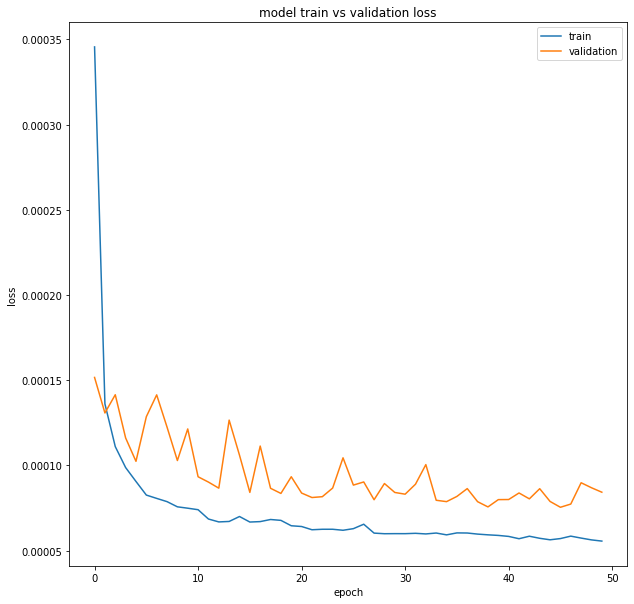

In [71]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'][0:])
plt.plot(history.history['val_loss'][0:])
plt.title('model train vs validation loss')
#plt.title('model train mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.legend(['train'], loc='upper right')
#plt.savefig('model_train_x_validation_loss.png')
plt.show()

#plt.plot(history.history['lr'])
#plt.title('model train lr')
#plt.ylabel('lr')
#plt.xlabel('epoch')
#plt.legend(['train'], loc='upper right')
##plt.savefig('model_train_x_validation_loss.png')
#
#plt.show()

In [72]:
#Resultados do Modelo
lstm_model = tf.keras.models.load_model(nome_modelo_treinado)
#y_pred = model_lstm(x_test) 
y_pred = lstm_model.predict(x_test)
print(f'y_pred.shape={y_pred.shape}')
print(f'y_test.shape={y_test.shape}')

y_pred.shape=(1968, 1)
y_test.shape=(1968, 1)


In [73]:
y_pred_scaled = y_pred
y_test_scaled = y_test

In [74]:
print(f'y_pred_scaled.shape={y_pred_scaled.shape}')
print(f'y_test_scaled.shape={y_test_scaled.shape}')

y_pred_scaled.shape=(1968, 1)
y_test_scaled.shape=(1968, 1)


In [75]:
#Similar inverse transform
y_pred = (y_pred_scaled * df_treino_y_std) + df_treino_y_mean
y_test = (y_test * df_treino_y_std) + df_treino_y_mean

In [76]:
print('R2_Score: ', r2_score(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))

#plt.hist((y_pred-y_test), bins = 5, cumulative = False,density=False)
#plt.title('Erro de predição de temperatura - TREINO_VALIDACAO')
#plt.xlim((y_pred-y_test).min(),(y_pred-y_test).max())
#plt.xlabel('Erro')
#plt.ylabel('Quantidade')
##plt.savefig('train_validation_erro_predição_temperatura.png')

#plt.show()


#R2_Score:  0.683364411916178
#RMSE:  11.137011996153753

R2_Score:  0.6738273774164358
RMSE:  11.302873071334199


## Infos treino/validação

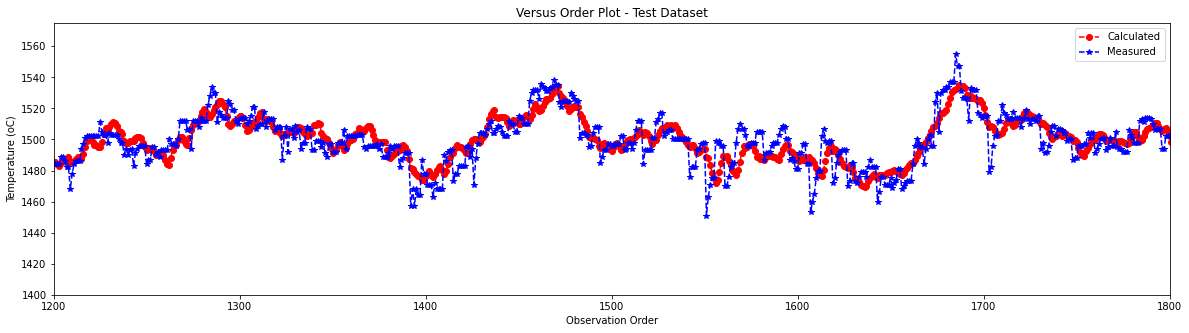

#####Teste dataset error evaluation#####
Test Size: 1968  Samples
The Percentage of Abs Error Smaller 3 oC is: 23.475609756097562 %
The Percentage of Abs Error Smaller 5 oC is: 39.735772357723576 %
The Percentage of Abs Error Smaller 7 oC is: 51.98170731707317 %
The Percentage of Abs Error Smaller 10 oC is: 67.3780487804878 %
The Percentage of Abs Error Smaller 15 oC is: 83.4349593495935 %
The Percentage of Abs Error Smaller 20 oC is: 91.869918699187 %


In [77]:
plt.figure(figsize=(20,5))
plt.plot((y_pred), c='r', marker = 'o', markersize=6, linestyle='--', label='Calculated')
plt.plot((y_test), c='b', marker = '*', markersize=6, linestyle='--', label='Measured')

plt.xlabel('Observation Order')
plt.ylabel('Temperature (oC)')
plt.xlim(1200,1800)
plt.ylim(1400, 1575)
plt.title('Versus Order Plot - Test Dataset')
plt.legend()

plt.show();

##### 

erro_test = y_pred-y_test
print('#####Teste dataset error evaluation#####')
print('Test Size:', len(erro_test), ' Samples')
print('The Percentage of Abs Error Smaller 3 oC is:', 100*(abs(erro_test)<=3).sum()/len(erro_test), '%')
print('The Percentage of Abs Error Smaller 5 oC is:', 100*(abs(erro_test)<=5).sum()/len(erro_test),'%')
print('The Percentage of Abs Error Smaller 7 oC is:', 100*(abs(erro_test)<=7).sum()/len(erro_test),'%')
print('The Percentage of Abs Error Smaller 10 oC is:', 100*(abs(erro_test)<=10).sum()/len(erro_test),'%')
print('The Percentage of Abs Error Smaller 15 oC is:', 100*(abs(erro_test)<=15).sum()/len(erro_test),'%')
print('The Percentage of Abs Error Smaller 20 oC is:', 100*(abs(erro_test)<=20).sum()/len(erro_test),'%')

# TESTE

In [78]:
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

df_teste = pd.read_csv('../AMT_BF_T_Model_Valid_RS.csv',date_parser=custom_date_parser,parse_dates=["Data"], index_col="Data")
df_teste.drop('Unnamed: 0', axis=1, inplace=True)

FileNotFoundError: ignored

In [ ]:
df_teste = df_teste[model_columns]

In [ ]:
df_teste["TEMPERATURA_ANTERIOR"] = df_teste['TEMPERATURA'].shift(1)

#Movimentação da coluna temperatura para ela ser a última coluna do dataset
df_teste.rename(columns={"TEMPERATURA": "TEMPERATURA_TO_REMOVE"},inplace=True)
df_teste['TEMPERATURA'] = df_teste['TEMPERATURA_TO_REMOVE']
df_teste.drop('TEMPERATURA_TO_REMOVE', axis=1, inplace=True)

df_teste.dropna(inplace=True)

In [ ]:
df_teste.shape

# Separa em x / y

In [ ]:
df_teste_x = df_teste.drop('TEMPERATURA', axis=1).to_numpy()
df_teste_y = df_teste['TEMPERATURA'].to_numpy()

In [ ]:
print(f'df_teste_x.shape={df_teste_x.shape}')
print(f'df_teste_y.shape={df_teste_x.shape}')

## Aplica scaler treinado

In [ ]:
#Similar transform
df_teste_x_scaled = (df_teste_x - df_treino_x_mean) / df_treino_x_std
df_teste_y_scaled = (df_teste_y - df_treino_y_mean) / df_treino_y_std

In [ ]:
teste_numpy_in, teste_numpy_out = to_sequences(SEQUENCE_SIZE, df_teste_x_scaled, df_teste_y_scaled)

In [ ]:
print(f"teste_numpy_in.shape {teste_numpy_in.shape}")
print(f"teste_numpy_out.shape {teste_numpy_out.shape}")

x_valid = teste_numpy_in.reshape(teste_numpy_in.shape[0], teste_numpy_in.shape[1], teste_numpy_in.shape[2])
y_valid = teste_numpy_out

print(f"x_valid.shape {x_valid.shape}")
print(f"y_valid.shape {y_valid.shape}")


In [ ]:
#Carrega modelo treinado
lstm_model_loaded = tf.keras.models.load_model(nome_modelo_treinado)

In [ ]:
#Resultados do Modelo
y_pred_valid = lstm_model_loaded.predict(x_valid)

y_pred_valid_scaled = y_pred_valid


#Similar inverse transform
y_pred_valid = (y_pred_valid_scaled * df_treino_y_std) + df_treino_y_mean
y_valid = (y_valid * df_treino_y_std) + df_treino_y_mean

In [ ]:
print('R2_Score: ', r2_score(y_valid, y_pred_valid))
print('RMSE: ', mean_squared_error(y_valid, y_pred_valid, squared=False))

## Infos Teste

In [ ]:
plt.show();

plt.figure(figsize=(20,5))
plt.plot((y_pred_valid), c='r', marker = 'o', markersize=6, linestyle='--', label='Calculated')
plt.plot((y_valid), c='b', marker = '*', markersize=6, linestyle='--', label='Measured')

plt.xlabel('Observation Order')
plt.ylabel('Temperature (oC)')
plt.xlim(1000,1200)
plt.ylim(1400, 1575)
plt.title('Versus Order Plot - Test Dataset')
plt.legend()


erro_valid = y_pred_valid-y_valid
print('#####Teste dataset error evaluation#####')
print('Test Size:', len(erro_valid), ' Samples')
print('The Percentage of Abs Error Smaller 3 oC is:', 100*(abs(erro_valid)<=3).sum()/len(erro_valid), '%')
print('The Percentage of Abs Error Smaller 5 oC is:', 100*(abs(erro_valid)<=5).sum()/len(erro_valid),'%')
print('The Percentage of Abs Error Smaller 7 oC is:', 100*(abs(erro_valid)<=7).sum()/len(erro_valid),'%')
print('The Percentage of Abs Error Smaller 10 oC is:', 100*(abs(erro_valid)<=10).sum()/len(erro_valid),'%')
print('The Percentage of Abs Error Smaller 15 oC is:', 100*(abs(erro_valid)<=15).sum()/len(erro_valid),'%')
print('The Percentage of Abs Error Smaller 20 oC is:', 100*(abs(erro_valid)<=20).sum()/len(erro_valid),'%')